# Rossmann销售预测
Kaggle项目地址：https://www.kaggle.com/c/rossmann-store-sales

**环境要求：**
* Python 3.x
* Keras
* 

## 1.数据分析

### 导入数据，用于数据分析

In [1]:
import visulization as vs
%matplotlib inline

data = vs.load_data()

print(data.head(3))

   Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  


### 可视化分析
#### 各个门店的年、月销售趋势可视化，随机选择动态的N个门店按月、按年显示

array([411, 406, 842, 560, 953])

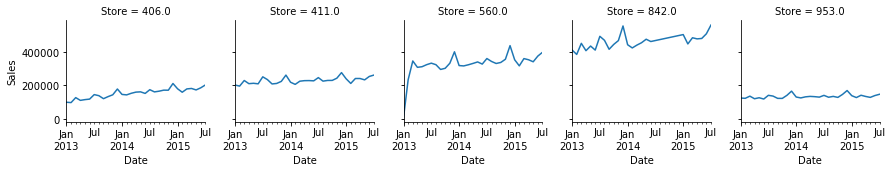

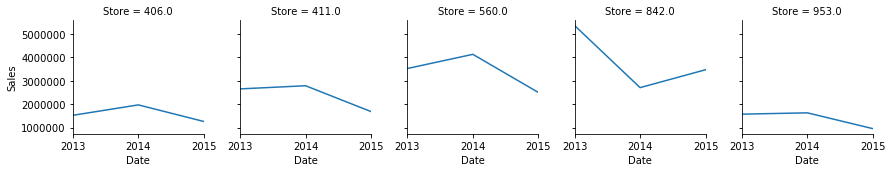

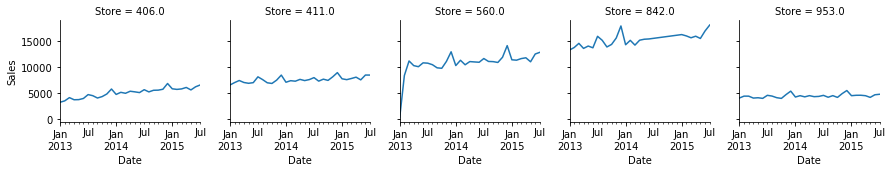

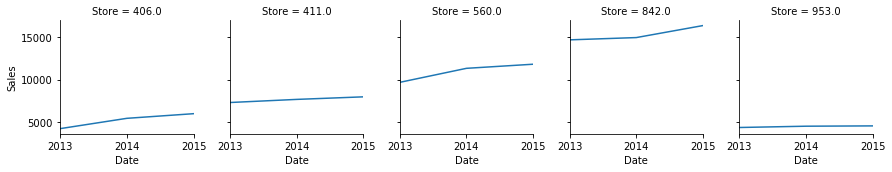

In [2]:
# Take 5 random stores to view the sales by dates, monthly & yearly view
# Monthly sum view
stores = vs.viewRandomStoreData(data,"M",'sum',size = 5)
# Yearly sum view
vs.viewStoreData(data,stores,"A",'sum')
# Monthly mean value view
vs.viewStoreData(data,stores, "M",'mean')
# Yearly mean value view
vs.viewStoreData(data,stores, "A",'mean')

#### 可视化分析结论
从上面的图示可以得到一些分析结论：
* 不同门店差异较大，所以门店编号需要作为特征值训练模型

### 其他维度的可视化比较
* Open与销售额
* Prom与销售额

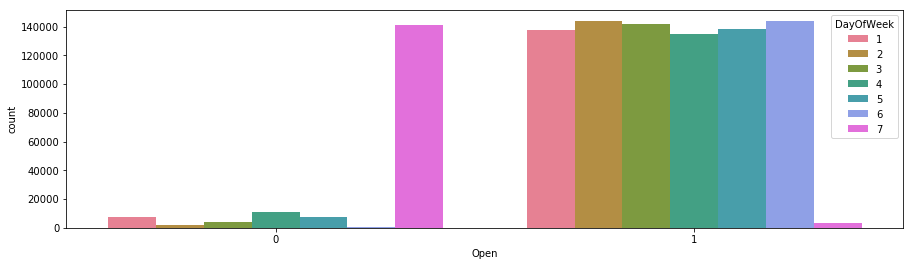

In [13]:
import seaborn as sns

all_data_file = "./data/train.csv"
rossmann_df = pd.read_csv(all_data_file, dtype={"StateHoliday":np.str},
                      parse_dates=['Date'])
    
fig, (axis1) = plt.subplots(1,1,figsize=(15,4))
sns.countplot(x='Open',hue='DayOfWeek', data = rossmann_df,palette="husl", ax=axis1)

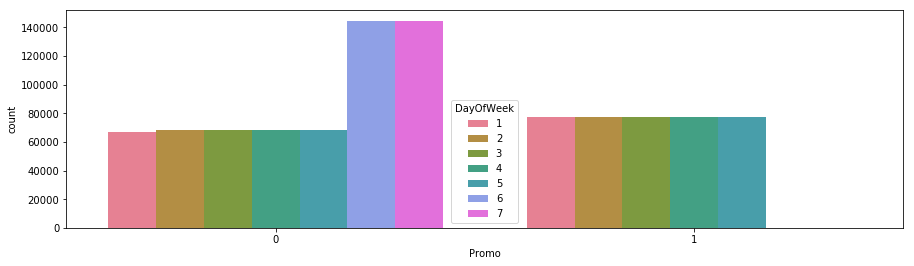

In [14]:
fig, (axis2) = plt.subplots(1,1,figsize=(15,4))
sns.countplot(x='Promo',hue='DayOfWeek', data = rossmann_df,palette="husl", ax=axis2)

## 2.数据预处理
为训练模型做数据准备，包括数据加载，序列化，归并整理，排序，编码

In [1]:
import prepare_data2 as raw_data

# Load data from csv files, as dict format
raw_data.read_data_as_dicts()

Titles:
['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']
3 samples:
[{'Store': '1115', 'DayOfWeek': '2', 'Date': '2013-01-01', 'Sales': '0', 'Customers': '0', 'Open': '0', 'Promo': '0', 'StateHoliday': 'a', 'SchoolHoliday': '1'}, {'Store': '1114', 'DayOfWeek': '2', 'Date': '2013-01-01', 'Sales': '0', 'Customers': '0', 'Open': '0', 'Promo': '0', 'StateHoliday': 'a', 'SchoolHoliday': '1'}, {'Store': '1113', 'DayOfWeek': '2', 'Date': '2013-01-01', 'Sales': '0', 'Customers': '0', 'Open': '0', 'Promo': '0', 'StateHoliday': 'a', 'SchoolHoliday': '1'}]

Titles:
['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
Titles:
['Store', 'State']
2 samples:
[{'Store': '1', 'StoreType': 'c', 'Assortment': 'a', 'CompetitionDistance': '1270', 'CompetitionOpenSinceMonth': '9', 'CompetitionOpenSinceYear': '2008', 'Promo2': '

In [2]:
# Prepare data for processing, including reformat, ordering, standanlize, encoding
(X,y) = raw_data.prepare_data_for_process()
print("prepare data complete")
#print(type(X))

Prepare data from processning
Number of train datapoints:  844338
46 41551
[  0 109   1   0   0   0   0   2] 5961
prepare data complete


### 数据分割
使用原训练数据集分割用于训练、验证和测试
* 划分训练集、验证集和测试集。本次使用原训练集中的5%作为测试集，10%作为验证集，剩下的85%作为训练集。

In [3]:
train_ratio = 0.85
validate_ratio = 0.1
test_ratio = 0.05

num_records = len(X)
train_size = int(train_ratio * num_records)
validate_size = int(validate_ratio * num_records)
test_size = int(test_ratio * num_records)

test_index = train_size + validate_size

X_train = X[:train_size]
X_val = X[train_size:test_index]
X_test = X[test_index:]
y_train = y[:train_size]
y_val = y[train_size:test_index]
y_test = y[test_index:]
print("Data split completed...")

Data split completed...


### 评价指标

本项目采用Kaggle中要求使用的**RMSPE**(Root Mean Square Percentage Error)作为评价指标

In [4]:
def score(y_act, y_pred):
    relative_err = numpy.square((y_act - y_pred) / y_act)
    return numpy.sqrt(numpy.sum(relative_err) / len(y_act))

def score_rmse(y_act, y_pred):
    return numpy.sqrt(numpy.mean((y_act - y_pred)**2))

def fit_estimator(X, y):
    from sklearn.linear_model import LinearRegression
    from sklearn.svm import LinearSVR
    import random

#     lsvr = LinearSVR(random_state=store_id)
    lsvr = LinearRegression()
    lsvr.fit(X, y)
    return lsvr

##  3.基准模型
考虑到每个店铺的不同， 对每个门店分别进行线性回归建模。
* 线性回归
* SVR： 测试中效果并不理想，故不使用

### 总体线性回归

In [5]:
import pandas as pd
import numpy

x_df_train_all = pd.DataFrame(X_train)
x_df_test_all = pd.DataFrame(X_test)

all_estimator = fit_estimator(x_df_train_all.as_matrix(),pd.Series(y_train))
y_pred_all = all_estimator.predict(x_df_test_all.as_matrix())

result = score(pd.Series(y_test), pd.Series(y_pred_all))
print("Overall Testing error:")
print(result)

Overall Testing error:
0.46641274712


### 基于门面的线性回归

In [7]:
def to_X_df(X, y):
    df = pd.DataFrame(X)
    df.columns = ['store_open', 'store_index', 'day_of_week', 'promo',
                      'year','month','day','comp_distance'] 
    df['Sales'] = pd.Series(y)
    return df

train_dic = dict(list(to_X_df(X_train, y_train).groupby('store_index')))
# print(train_dic[2].head(2))

test_dic = dict(list(to_X_df(X_test, y_test).groupby('store_index')))
# print(test_dic[2].head(2))

y_observed = []
y_predicts = []

for s_id in test_dic.keys():
    # Train data of Store
    train_of_store = train_dic[s_id]
    y_train_of_store = train_of_store['Sales']
    x_train_of_store = train_of_store.drop(['Sales','store_index'],axis =1)
    estimator = fit_estimator(x_train_of_store.as_matrix(),y_train_of_store)
    
    # Test data of Store
    test_of_store = test_dic[s_id]
    y_test_of_store = test_of_store['Sales']
    x_test_of_store = test_of_store.drop(['Sales','store_index'],axis =1)
    
    y_pred = estimator.predict(x_test_of_store)
    
    y_observed.extend(y_test_of_store)
    y_predicts.extend(y_pred)
#     print("Extended {} items".format(len(y_pred)))
    
result = score(pd.Series(y_observed), pd.Series(y_predicts))
print("Testing error:")
print(result)

Testing error:
0.162214296901


### 基准模型结果分析
通过测试可以得到结论： 
* 无论是线性模型，还是SVR模型，在测试集上的结果并不是很理想，错误率达16%-45%。SVR结果不如Linear 
* 在分别对门面做线性回归时，结果比不区分门店的回归效果要好64%

## 4.Embedding神经网络模型的建立和训练
本项目的核心部分，主要包括：
* 实现基于Keras的Embedding神经网络，根据数据特征构建网络。使用的相关指标：
 * 评估指标：和基准模型一样为RMSPE
* 在建立的模型上使用训练集，验证集训练模型
 * 对训练集的数据进行一定规模的“取样”，并执行多次训练

In [10]:
import numpy
# 导入神经网络实现
from network2 import Enbedding_Network

def sample(X, y, n):
    '''random samples'''
    num_row = X.shape[0]
    indices = numpy.random.randint(num_row, size=n)
    return X[indices, :], y[indices]

# 可动态调整，这里选择20万个用于batch训练，并执行5次取样，每次取样训练6次
batch_size = 200000
samples = 5
fit_epoch = 6

models = []

print("Build embedding network with Keras ...")
for i in range(samples):
    X_train, y_train = sample(X_train, y_train, batch_size)  # take a random sample for training
    print("Number of samples used for training: " + str(y_train.shape[0]))
    model = Enbedding_Network(X_train, y_train, X_val, y_val, fit_epoch)
    model.fit_model(X_train, y_train, X_val, y_val)
    models.append(model)

# Save modle    
#with open('models.pickle', 'wb') as f:
#    pickle.dump(models, f)

Build embedding network with Keras ...
Number of samples used for training: 200000
Train on 200000 samples, validate on 84433 samples
Epoch 1/6
200000/200000 [==============================] - 44s - loss: 0.0126 - val_loss: 0.0136
Epoch 2/6
200000/200000 [==============================] - 43s - loss: 0.0061 - val_loss: 0.0135
Epoch 3/6
200000/200000 [==============================] - 44s - loss: 0.0046 - val_loss: 0.0147
Epoch 4/6
200000/200000 [==============================] - 44s - loss: 0.0037 - val_loss: 0.0144
Epoch 5/6
200000/200000 [==============================] - 43s - loss: 0.0031 - val_loss: 0.0146
Epoch 6/6
200000/200000 [==============================] - 45s - loss: 0.0028 - val_loss: 0.0155
 Error rate for validation dataset:  0.01550380935880s

Number of samples used for training: 200000
Train on 200000 samples, validate on 84433 samples
Epoch 1/6
200000/200000 [==============================] - 46s - loss: 0.0125 - val_loss: 0.0132
Epoch 2/6
200000/200000 [===========

## 5.模型预测及结果分析
在预先选定的测试集上，执行Keras模型的预测（predict），并将多个模型的平均值作为最终结果，同时计算出错误率。

In [14]:
# Evaluate model 
def test_models(models, X, y):
    assert(min(y) > 0)
    predict_sales = numpy.array([model.predict(X) for model in models])
    predicted_sales_mean = predict_sales.mean(axis=0)
    relative_err = numpy.absolute((y - predicted_sales_mean) / y)
    result = numpy.sum(relative_err) / len(y)
    return result,predicted_sales_mean

print("Testing error rate ...")
r_val,predicted_sales_mean = test_models(models, X_test, y_test)
print(r_val)

Testing error rate ...
0.125857534506


**测试集结果：**       
在测试集上预测结果误差约为0.126，结果较为理想。

### 结果可视化对比
将在测试集的中随机选择这个商店，进行销售了（Sales）的可视化对比，从而直观了解预测的效果。整个过程包含以下几个步骤：
* 解码（LabelEncoder）测试集的数据，并格式化时间
* 构造相应的预测结果序列
* 随机从测试集中选择某个商店（view_store_id）来进行可视化
* 在同一个图上画出选定商店的实际和预测销售额

In [12]:
# 反序列化数据
import pickle 
import numpy as np
import pandas as pd

# Restore label encoder for decoding
encoders = []
with open('les.pickle', 'rb') as le:
    les = pickle.load(le)
    encoders = les

# Prepare labels dataframe
test_df = pd.DataFrame(X_test)
test_df.columns = ['store_open', 'store_index', 'day_of_week', 'promo',
                  'year','month','day','state'] 

for idx,value in enumerate(test_df.columns):
    test_df[value] = encoders[idx].inverse_transform(test_df[value])

test_df.drop(['store_open','day_of_week','promo','state'], axis = 1, inplace = True)
test_df['Date'] = pd.to_datetime(test_df[['year','month','day']])
test_df.drop(['year','month','day'], axis = 1, inplace = True)
test_df['Sales'] = pd.Series(y_test)    
# print(test_df.head(2))
# print(type(test_df['Date'][2]))
# print("")

# Prepare prediction dataframe
prd_df = pd.DataFrame({'Date':[],'Sales':[]})
prd_df['Date'] = test_df['Date']
prd_df['Sales'] = pd.Series(predicted_sales_mean)
# print(prd_df.head(2))
# print("")

# Prepare plot data
view_store_id = np.random.choice(len(test_df['store_index'].unique()),1)[0]
print("Picking Store {0} to plot:".format(str(view_store_id)))
plot_df = test_df[test_df.store_index == str(view_store_id)].copy()
plot_sales_df = prd_df.loc[plot_df.index]

plot_df.drop(['store_index'],axis = 1, inplace = True)
plot_df.set_index(['Date'], inplace=True)
plot_df.index.name=None
plot_sales_df.set_index(['Date'], inplace=True)
plot_sales_df.index.name=None

# print(plot_df.head(2))
# print(plot_sales_df.head(2))

print("done")

Picking Store 656 to plot:
done


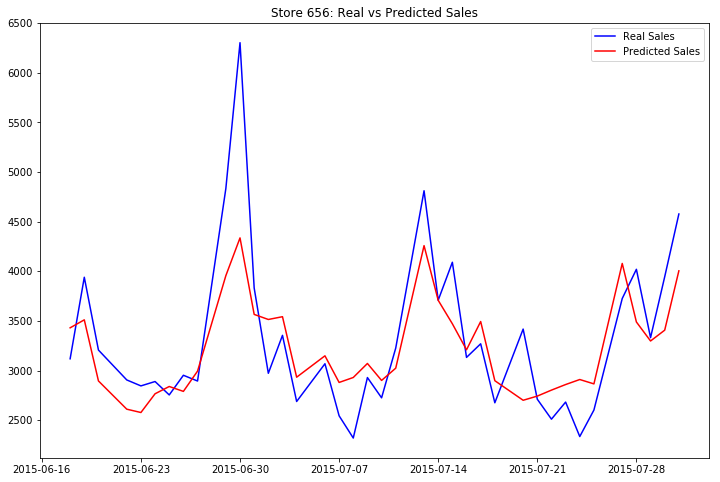

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
orig = plt.plot(plot_df, color='blue', label='Real Sales')
predicted = plt.plot(plot_sales_df, color='red', label='Predicted Sales')
plt.legend(loc='best')
plt.title('Store {0}: Real vs Predicted Sales'.format(str(view_store_id)))
plt.show()

## 6. 预测效果及其实用性分析

## Reference
* PyFlux: http://www.pyflux.com/docs/getting_started.html         
* Entity Embeddings of Categorical Variables:https://arxiv.org/abs/1604.06737
* Keras: https://keras.io/models/about-keras-models/
* SARIMAX：http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html